In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance

c:\Documents\Capstone\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
path = "../../Dataset/"
x_train = pd.read_csv(path + "X_train_winsorized.csv")
y_train = pd.read_csv(path + "Y_train_winsorized.csv")
x_validation = pd.read_csv(path + "X_validation.csv")
y_validation = pd.read_csv(path + "Y_validation.csv")
x_test = pd.read_csv(path + "X_test.csv")
y_test = pd.read_csv(path + "Y_test.csv")

In [66]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_validation.shape, y_validation.shape

((1084578, 46), (1084578, 1), (36537, 46), (36537, 1), (58299, 46), (58299, 1))

In [67]:
x_train = x_train.drop(columns=['StartDate','EventDate','Duration','tic'])
x_test = x_test.drop(columns=['StartDate','EventDate','Duration','tic'])
x_validation = x_validation.drop(columns=['StartDate','EventDate','Duration','tic'])

In [68]:
# mini sample to try:
msk = np.random.rand(len(x_train)) < 0.0001
x_train_sample=x_train[msk]
y_train_sample=y_train[msk]

In [69]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'precision', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    
    match optimisation_metric:
        case "auc":
            return auc
        case "recall":
            return recall
        case "precision":
            return precision
        case "f1":
            return f1
        case _:
            return auc
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-10-31 22:15:34,824] A new study created in memory with name: no-name-4493ad67-067d-4fd5-8c26-bc9d5bc06c58
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.234237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:15:56,089] Trial 0 finished with value: 0.9630608938848729 and parameters: {'num_leaves': 228, 'lambda_l1': 0.09218805864687968, 'lambda_l2': 4.72443136215467e-05, 'feature_fraction': 0.42307895641852006, 'min_child_samples': 90, 'learning_rate': 0.0006033303886725838, 'max_depth': 76, 'num_boost_round': 163}. Best is trial 0 with value: 0.9630608938848729.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:16:37,204] Trial 1 finished with value: 0.9580934568993049 and parameters: {'num_leaves': 92, 'lambda_l1': 9.734495001782186, 'lambda_l2': 1.0438834870463761e-06, 'feature_fraction': 0.7934952285024837, 'min_child_samples': 47, 'learning_rate': 1.2314666504933761e-05, 'max_depth': 113, 'num_boost_round': 354}. Best is trial 0 with value: 0.9630608938848729.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:17:20,801] Trial 2 finished with value: 0.8976394652557482 and parameters: {'num_leaves': 205, 'lambda_l1': 1.7010165801693902e-05, 'lambda_l2': 1.1193698095817122e-08, 'feature_fraction': 0.7258398117153113, 'min_child_samples': 7, 'learning_rate': 0.0909708429874899, 'max_depth': 67, 'num_boost_round': 201}. Best is trial 0 with value: 0.9630608938848729.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2023-10-31 22:17:33,487] Trial 3 finished with value: 0.770562770799036 and parameters: {'num_leaves': 123, 'lambda_l1': 1.9921460108674877e-06, 'lambda_l2': 0.034845648389317654, 'feature_fraction': 0.5392315443417008, 'min_child_samples': 28, 'learning_rate': 1.4347171413651048, 'max_depth': 131, 'num_boost_round': 265}. Best is trial 0 with value: 0.9630608938848729.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:18:03,703] Trial 4 finished with value: 0.9614936787452105 and parameters: {'num_leaves': 224, 'lambda_l1': 3.2859725044685207e-07, 'lambda_l2': 4.424758103380678e-06, 'feature_fraction': 0.5416147240501037, 'min_child_samples': 40, 'learning_rate': 8.711804681169885e-07, 'max_depth': 253, 'num_boost_round': 208}. Best is trial 0 with value: 0.9630608938848729.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:18:42,735] Trial 5 finished with value: 0.9700020106286062 and parameters: {'num_leaves': 156, 'lambda_l1': 3.298582535769905e-06, 'lambda_l2': 2.588211859935102e-07, 'feature_fraction': 0.49578655898822077, 'min_child_samples': 71, 'learning_rate': 0.04440782252570944, 'max_depth': 173, 'num_boost_round': 375}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-31 22:19:02,845] Trial 6 finished with value: 0.8334148354701083 and parameters: {'num_leaves': 246, 'lambda_l1': 0.00022132872281798878, 'lambda_l2': 0.10284465305132819, 'feature_fraction': 0.9144228741922199, 'min_child_samples': 72, 'learning_rate': 0.61282296989863, 'max_depth': 238, 'num_boost_round': 377}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:19:37,279] Trial 7 finished with value: 0.9439664168262326 and parameters: {'num_leaves': 228, 'lambda_l1': 0.0004772542000613013, 'lambda_l2': 8.890327169065553e-06, 'feature_fraction': 0.9641525985923793, 'min_child_samples': 67, 'learning_rate': 1.2735922929015723e-07, 'max_depth': 113, 'num_boost_round': 203}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.210508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:20:05,940] Trial 8 finished with value: 0.9609212171965725 and parameters: {'num_leaves': 157, 'lambda_l1': 0.0006358809860413242, 'lambda_l2': 7.891895392173774e-06, 'feature_fraction': 0.5240907393724843, 'min_child_samples': 55, 'learning_rate': 2.1937979117064335e-08, 'max_depth': 199, 'num_boost_round': 271}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:20:20,675] Trial 9 finished with value: 0.5 and parameters: {'num_leaves': 124, 'lambda_l1': 5.688234848482307e-08, 'lambda_l2': 0.0025875516767091384, 'feature_fraction': 0.7501813197328373, 'min_child_samples': 85, 'learning_rate': 9.527804162847115, 'max_depth': 5, 'num_boost_round': 314}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:21:17,708] Trial 10 finished with value: 0.9687036979629778 and parameters: {'num_leaves': 59, 'lambda_l1': 2.0425823535101206e-08, 'lambda_l2': 4.357154501636293, 'feature_fraction': 0.6281270459054613, 'min_child_samples': 100, 'learning_rate': 0.005683063882764933, 'max_depth': 181, 'num_boost_round': 486}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:21:53,587] Trial 11 finished with value: 0.9683389849971303 and parameters: {'num_leaves': 20, 'lambda_l1': 1.4582424663289547e-08, 'lambda_l2': 7.797417785625779, 'feature_fraction': 0.6275400515354262, 'min_child_samples': 97, 'learning_rate': 0.007846133704727611, 'max_depth': 180, 'num_boost_round': 499}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:22:26,844] Trial 12 finished with value: 0.9688901341008507 and parameters: {'num_leaves': 47, 'lambda_l1': 1.2316145668745734e-08, 'lambda_l2': 0.0018916170906224156, 'feature_fraction': 0.4022122588770588, 'min_child_samples': 76, 'learning_rate': 0.006907321294323581, 'max_depth': 177, 'num_boost_round': 475}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:23:08,160] Trial 13 finished with value: 0.9620794844495014 and parameters: {'num_leaves': 172, 'lambda_l1': 1.2856717627369e-06, 'lambda_l2': 0.0008314772135930077, 'feature_fraction': 0.4263993775304563, 'min_child_samples': 72, 'learning_rate': 3.864911139058603e-05, 'max_depth': 154, 'num_boost_round': 415}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:23:23,131] Trial 14 finished with value: 0.9686397333395624 and parameters: {'num_leaves': 6, 'lambda_l1': 1.039888215066349e-08, 'lambda_l2': 2.3214321348362389e-07, 'feature_fraction': 0.4097771178922325, 'min_child_samples': 58, 'learning_rate': 0.03606888343845634, 'max_depth': 223, 'num_boost_round': 429}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:23:56,672] Trial 15 finished with value: 0.9604066894770772 and parameters: {'num_leaves': 70, 'lambda_l1': 3.4474101066025314e-07, 'lambda_l2': 0.00013650142652181624, 'feature_fraction': 0.4046951849482806, 'min_child_samples': 79, 'learning_rate': 0.0008425920893418386, 'max_depth': 154, 'num_boost_round': 440}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:24:30,328] Trial 16 finished with value: 0.9656261645436451 and parameters: {'num_leaves': 164, 'lambda_l1': 8.686603554293247e-06, 'lambda_l2': 1.134698791619184e-07, 'feature_fraction': 0.49876610094802026, 'min_child_samples': 63, 'learning_rate': 0.055713674088549416, 'max_depth': 202, 'num_boost_round': 367}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:25:08,262] Trial 17 finished with value: 0.9606467751241798 and parameters: {'num_leaves': 92, 'lambda_l1': 2.2247656746781373e-07, 'lambda_l2': 0.0006807987254718914, 'feature_fraction': 0.4917260739771874, 'min_child_samples': 82, 'learning_rate': 0.00011771308616992825, 'max_depth': 139, 'num_boost_round': 453}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:25:17,922] Trial 18 finished with value: 0.9579101316688851 and parameters: {'num_leaves': 43, 'lambda_l1': 1.1850343230952585e-07, 'lambda_l2': 6.851400606375898e-05, 'feature_fraction': 0.6071448950455767, 'min_child_samples': 35, 'learning_rate': 0.0028838216284345288, 'max_depth': 87, 'num_boost_round': 105}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:25:50,560] Trial 19 finished with value: 0.9620557433136775 and parameters: {'num_leaves': 187, 'lambda_l1': 2.0935372684330596e-05, 'lambda_l2': 1.2223788345851359e-08, 'feature_fraction': 0.47575800369951005, 'min_child_samples': 21, 'learning_rate': 0.0002689643744248956, 'max_depth': 178, 'num_boost_round': 321}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-31 22:26:12,214] Trial 20 finished with value: 0.8430817347817137 and parameters: {'num_leaves': 140, 'lambda_l1': 7.618707643903526e-08, 'lambda_l2': 0.006759498151027177, 'feature_fraction': 0.5771569239775274, 'min_child_samples': 51, 'learning_rate': 0.26741725917747966, 'max_depth': 17, 'num_boost_round': 397}. Best is trial 5 with value: 0.9700020106286062.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:26:56,655] Trial 21 finished with value: 0.9705735170740791 and parameters: {'num_leaves': 64, 'lambda_l1': 1.1415166667368539e-08, 'lambda_l2': 1.1861424490800487, 'feature_fraction': 0.6367732960510735, 'min_child_samples': 99, 'learning_rate': 0.00735133975903383, 'max_depth': 174, 'num_boost_round': 493}. Best is trial 21 with value: 0.9705735170740791.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:27:40,596] Trial 22 finished with value: 0.9724371962362603 and parameters: {'num_leaves': 101, 'lambda_l1': 1.0218460784662919e-08, 'lambda_l2': 0.3487355172094161, 'feature_fraction': 0.675566417558414, 'min_child_samples': 88, 'learning_rate': 0.015217127571811626, 'max_depth': 213, 'num_boost_round': 465}. Best is trial 22 with value: 0.9724371962362603.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:28:23,099] Trial 23 finished with value: 0.9698097892944177 and parameters: {'num_leaves': 92, 'lambda_l1': 8.444855950255111e-07, 'lambda_l2': 0.6472675297184497, 'feature_fraction': 0.6749290607307226, 'min_child_samples': 86, 'learning_rate': 0.06087734317756935, 'max_depth': 222, 'num_boost_round': 460}. Best is trial 22 with value: 0.9724371962362603.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:29:03,937] Trial 24 finished with value: 0.9718260939424191 and parameters: {'num_leaves': 110, 'lambda_l1': 5.851777098023481e-08, 'lambda_l2': 0.42692139085040964, 'feature_fraction': 0.6696651906626496, 'min_child_samples': 95, 'learning_rate': 0.01768173740516242, 'max_depth': 204, 'num_boost_round': 410}. Best is trial 22 with value: 0.9724371962362603.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:30:09,352] Trial 25 finished with value: 0.9638105952923347 and parameters: {'num_leaves': 113, 'lambda_l1': 6.16182300939389e-08, 'lambda_l2': 0.5434745488476096, 'feature_fraction': 0.6798775294258064, 'min_child_samples': 94, 'learning_rate': 0.001343430328215274, 'max_depth': 206, 'num_boost_round': 500}. Best is trial 22 with value: 0.9724371962362603.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:30:49,427] Trial 26 finished with value: 0.9721920894753743 and parameters: {'num_leaves': 76, 'lambda_l1': 1.0069378344099474e-08, 'lambda_l2': 1.4308000165069301, 'feature_fraction': 0.6626856426241237, 'min_child_samples': 100, 'learning_rate': 0.012468187595285552, 'max_depth': 228, 'num_boost_round': 415}. Best is trial 22 with value: 0.9724371962362603.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-10-31 22:31:25,873] Trial 27 finished with value: 0.8447571494656771 and parameters: {'num_leaves': 107, 'lambda_l1': 6.64938261150706e-08, 'lambda_l2': 0.11704501353961597, 'feature_fraction': 0.7752767372392937, 'min_child_samples': 91, 'learning_rate': 0.30011596462837425, 'max_depth': 256, 'num_boost_round': 406}. Best is trial 22 with value: 0.9724371962362603.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:32:22,238] Trial 28 finished with value: 0.9638286058091667 and parameters: {'num_leaves': 137, 'lambda_l1': 4.0264144110471254e-07, 'lambda_l2': 0.012635063962227357, 'feature_fraction': 0.7019034838686341, 'min_child_samples': 90, 'learning_rate': 0.0016831459627073204, 'max_depth': 222, 'num_boost_round': 340}. Best is trial 22 with value: 0.9724371962362603.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:33:03,261] Trial 29 finished with value: 0.9724920464466122 and parameters: {'num_leaves': 78, 'lambda_l1': 4.177852758233865e-08, 'lambda_l2': 2.0181809950935086, 'feature_fraction': 0.6711228444767344, 'min_child_samples': 90, 'learning_rate': 0.016060274781962626, 'max_depth': 235, 'num_boost_round': 430}. Best is trial 29 with value: 0.9724920464466122.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.172007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:33:51,575] Trial 30 finished with value: 0.9594485299816161 and parameters: {'num_leaves': 80, 'lambda_l1': 7.54482985834686e-07, 'lambda_l2': 3.6543940817889617, 'feature_fraction': 0.8031544714637249, 'min_child_samples': 87, 'learning_rate': 0.0004425927449788151, 'max_depth': 237, 'num_boost_round': 451}. Best is trial 29 with value: 0.9724920464466122.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.205397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:34:32,991] Trial 31 finished with value: 0.9714228766746777 and parameters: {'num_leaves': 104, 'lambda_l1': 4.695761886506909e-08, 'lambda_l2': 0.2233806604106115, 'feature_fraction': 0.6587259801410837, 'min_child_samples': 94, 'learning_rate': 0.01669907067589241, 'max_depth': 207, 'num_boost_round': 394}. Best is trial 29 with value: 0.9724920464466122.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:35:02,643] Trial 32 finished with value: 0.9729538524713812 and parameters: {'num_leaves': 32, 'lambda_l1': 1.2424674959919e-07, 'lambda_l2': 2.663956647795952, 'feature_fraction': 0.7001673548740147, 'min_child_samples': 80, 'learning_rate': 0.01648344715350724, 'max_depth': 239, 'num_boost_round': 426}. Best is trial 32 with value: 0.9729538524713812.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:35:43,003] Trial 33 finished with value: 0.9633960532299187 and parameters: {'num_leaves': 34, 'lambda_l1': 1.7643633738040335e-07, 'lambda_l2': 1.6899893364369325, 'feature_fraction': 0.7102577337699985, 'min_child_samples': 78, 'learning_rate': 0.0032915415441275354, 'max_depth': 240, 'num_boost_round': 432}. Best is trial 32 with value: 0.9729538524713812.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:36:08,152] Trial 34 finished with value: 0.7200578978081091 and parameters: {'num_leaves': 35, 'lambda_l1': 2.9170681071217688e-08, 'lambda_l2': 2.581448616322116, 'feature_fraction': 0.727898685886404, 'min_child_samples': 82, 'learning_rate': 0.1354701756502037, 'max_depth': 233, 'num_boost_round': 468}. Best is trial 32 with value: 0.9729538524713812.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:36:38,540] Trial 35 finished with value: 0.9732779599083713 and parameters: {'num_leaves': 79, 'lambda_l1': 1.7700513818499836e-07, 'lambda_l2': 7.715420410685327, 'feature_fraction': 0.6024160262067556, 'min_child_samples': 89, 'learning_rate': 0.02923648798629396, 'max_depth': 252, 'num_boost_round': 350}. Best is trial 35 with value: 0.9732779599083713.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:36:53,601] Trial 36 finished with value: 0.8256690033765899 and parameters: {'num_leaves': 55, 'lambda_l1': 1.991245840621547e-07, 'lambda_l2': 0.04843429466897736, 'feature_fraction': 0.5950869481635861, 'min_child_samples': 64, 'learning_rate': 0.12201925587613306, 'max_depth': 252, 'num_boost_round': 340}. Best is trial 35 with value: 0.9732779599083713.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:37:02,029] Trial 37 finished with value: 0.9583250284839052 and parameters: {'num_leaves': 3, 'lambda_l1': 2.1020375232449376e-06, 'lambda_l2': 9.065283855944804, 'feature_fraction': 0.5608723512610944, 'min_child_samples': 7, 'learning_rate': 0.023881113422562477, 'max_depth': 248, 'num_boost_round': 265}. Best is trial 35 with value: 0.9732779599083713.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2023-10-31 22:37:32,797] Trial 38 finished with value: 0.7665361650086439 and parameters: {'num_leaves': 91, 'lambda_l1': 5.470104105026699e-07, 'lambda_l2': 9.79757072172954, 'feature_fraction': 0.5789437546166157, 'min_child_samples': 90, 'learning_rate': 1.2352189078662608, 'max_depth': 215, 'num_boost_round': 294}. Best is trial 35 with value: 0.9732779599083713.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:38:01,377] Trial 39 finished with value: 0.9587478117222049 and parameters: {'num_leaves': 20, 'lambda_l1': 4.828336571774684e-06, 'lambda_l2': 0.19992474375618258, 'feature_fraction': 0.6180869485170748, 'min_child_samples': 74, 'learning_rate': 0.0019236883670429737, 'max_depth': 193, 'num_boost_round': 384}. Best is trial 35 with value: 0.9732779599083713.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:38:37,975] Trial 40 finished with value: 0.8457241504875829 and parameters: {'num_leaves': 86, 'lambda_l1': 3.867442452411522e-08, 'lambda_l2': 0.7413319094337583, 'feature_fraction': 0.7335590543964766, 'min_child_samples': 69, 'learning_rate': 0.10621210037644009, 'max_depth': 242, 'num_boost_round': 355}. Best is trial 35 with value: 0.9732779599083713.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:39:20,474] Trial 41 finished with value: 0.9729146932416026 and parameters: {'num_leaves': 71, 'lambda_l1': 2.381639814173108e-08, 'lambda_l2': 1.93449072992552, 'feature_fraction': 0.6511590623626538, 'min_child_samples': 83, 'learning_rate': 0.021421190850978686, 'max_depth': 227, 'num_boost_round': 422}. Best is trial 35 with value: 0.9732779599083713.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.228203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:39:58,498] Trial 42 finished with value: 0.9762641581764362 and parameters: {'num_leaves': 71, 'lambda_l1': 1.3485202981539115e-07, 'lambda_l2': 3.2235080070706976, 'feature_fraction': 0.6951446198551978, 'min_child_samples': 82, 'learning_rate': 0.028809878905610303, 'max_depth': 216, 'num_boost_round': 434}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:40:29,652] Trial 43 finished with value: 0.9726839948941822 and parameters: {'num_leaves': 51, 'lambda_l1': 1.392434743227393e-07, 'lambda_l2': 3.2335258727058123, 'feature_fraction': 0.6379240253599562, 'min_child_samples': 82, 'learning_rate': 0.04717994317121474, 'max_depth': 191, 'num_boost_round': 437}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:40:50,512] Trial 44 finished with value: 0.8252433275401323 and parameters: {'num_leaves': 25, 'lambda_l1': 1.7320130526253411e-07, 'lambda_l2': 4.110963093464658, 'feature_fraction': 0.6015471007805768, 'min_child_samples': 82, 'learning_rate': 0.5186860101502623, 'max_depth': 188, 'num_boost_round': 367}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:41:09,058] Trial 45 finished with value: 0.9718840550602239 and parameters: {'num_leaves': 51, 'lambda_l1': 2.2169880623485035e-06, 'lambda_l2': 4.052480581931209, 'feature_fraction': 0.6388066064836213, 'min_child_samples': 77, 'learning_rate': 0.060934917939752545, 'max_depth': 108, 'num_boost_round': 240}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:41:53,762] Trial 46 finished with value: 0.965837351497831 and parameters: {'num_leaves': 69, 'lambda_l1': 5.685725940924378e-07, 'lambda_l2': 0.062256791481474415, 'feature_fraction': 0.6995511276515847, 'min_child_samples': 66, 'learning_rate': 0.003504895223122898, 'max_depth': 154, 'num_boost_round': 442}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.216821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:42:19,937] Trial 47 finished with value: 0.9723569675703725 and parameters: {'num_leaves': 38, 'lambda_l1': 1.2139317729891598e-07, 'lambda_l2': 0.985656655403462, 'feature_fraction': 0.6444250236977183, 'min_child_samples': 58, 'learning_rate': 0.03389885972027265, 'max_depth': 163, 'num_boost_round': 386}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split require

[I 2023-10-31 22:42:36,795] Trial 48 finished with value: 0.8023729456276688 and parameters: {'num_leaves': 55, 'lambda_l1': 2.960773849160194e-08, 'lambda_l2': 0.15795633946001986, 'feature_fraction': 0.5456167902258697, 'min_child_samples': 84, 'learning_rate': 2.2097739328705166, 'max_depth': 216, 'num_boost_round': 478}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:43:02,998] Trial 49 finished with value: 0.9668653972563324 and parameters: {'num_leaves': 25, 'lambda_l1': 1.391543052070159e-06, 'lambda_l2': 9.32826550212776, 'feature_fraction': 0.6220287756048493, 'min_child_samples': 44, 'learning_rate': 0.006054555018831973, 'max_depth': 193, 'num_boost_round': 418}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:43:17,991] Trial 50 finished with value: 0.9707116795691099 and parameters: {'num_leaves': 13, 'lambda_l1': 3.190621646953249e-07, 'lambda_l2': 1.7306089631001043, 'feature_fraction': 0.7564502627299211, 'min_child_samples': 72, 'learning_rate': 0.03869197499703467, 'max_depth': 254, 'num_boost_round': 290}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:43:42,015] Trial 51 finished with value: 0.6459462037869239 and parameters: {'num_leaves': 66, 'lambda_l1': 3.151902521648509e-08, 'lambda_l2': 2.7845614879857328, 'feature_fraction': 0.6968879928860693, 'min_child_samples': 80, 'learning_rate': 0.17453607927334375, 'max_depth': 234, 'num_boost_round': 426}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:44:17,093] Trial 52 finished with value: 0.9688557230982368 and parameters: {'num_leaves': 46, 'lambda_l1': 1.1312368628775656e-07, 'lambda_l2': 0.36835575715061963, 'feature_fraction': 0.6469406813958063, 'min_child_samples': 92, 'learning_rate': 0.010311806412237586, 'max_depth': 242, 'num_boost_round': 444}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:44:51,109] Trial 53 finished with value: 0.971652210589005 and parameters: {'num_leaves': 77, 'lambda_l1': 3.136794580936773e-08, 'lambda_l2': 1.8013071504928038, 'feature_fraction': 0.596381999293423, 'min_child_samples': 85, 'learning_rate': 0.03023265135471531, 'max_depth': 226, 'num_boost_round': 398}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:45:21,572] Trial 54 finished with value: 0.9671491993397455 and parameters: {'num_leaves': 60, 'lambda_l1': 3.5310449510221597e-07, 'lambda_l2': 4.621737573335565, 'feature_fraction': 0.6529592029527965, 'min_child_samples': 76, 'learning_rate': 0.07342722441440529, 'max_depth': 243, 'num_boost_round': 432}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:46:12,835] Trial 55 finished with value: 0.9629713324966267 and parameters: {'num_leaves': 123, 'lambda_l1': 2.2446173804559863e-08, 'lambda_l2': 0.7263554979367801, 'feature_fraction': 0.6184839212760312, 'min_child_samples': 97, 'learning_rate': 0.0009828507775513674, 'max_depth': 232, 'num_boost_round': 479}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:47:07,049] Trial 56 finished with value: 0.9673736212949365 and parameters: {'num_leaves': 251, 'lambda_l1': 9.81905248288325e-07, 'lambda_l2': 5.174440548686229, 'feature_fraction': 0.6844942624946311, 'min_child_samples': 87, 'learning_rate': 0.004439570540009951, 'max_depth': 215, 'num_boost_round': 347}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:47:39,126] Trial 57 finished with value: 0.7257149465677085 and parameters: {'num_leaves': 79, 'lambda_l1': 1.038322481674014e-07, 'lambda_l2': 2.037693852583118, 'feature_fraction': 0.7184953674924781, 'min_child_samples': 80, 'learning_rate': 0.2587866650021493, 'max_depth': 51, 'num_boost_round': 454}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:48:08,742] Trial 58 finished with value: 0.9695005541781451 and parameters: {'num_leaves': 44, 'lambda_l1': 1.8854806535468806e-07, 'lambda_l2': 0.9862647517048377, 'feature_fraction': 0.6889852998005875, 'min_child_samples': 70, 'learning_rate': 0.009163013235529127, 'max_depth': 198, 'num_boost_round': 326}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:48:44,314] Trial 59 finished with value: 0.9708811967366254 and parameters: {'num_leaves': 97, 'lambda_l1': 2.040376984356253e-08, 'lambda_l2': 0.2729432684731882, 'feature_fraction': 0.6308578241386712, 'min_child_samples': 75, 'learning_rate': 0.022988164029297237, 'max_depth': 224, 'num_boost_round': 374}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:48:59,763] Trial 60 finished with value: 0.96898397980901 and parameters: {'num_leaves': 32, 'lambda_l1': 7.406566261666369e-08, 'lambda_l2': 0.0968142357053177, 'feature_fraction': 0.6577168806614739, 'min_child_samples': 83, 'learning_rate': 0.06752744629407388, 'max_depth': 249, 'num_boost_round': 235}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:49:44,873] Trial 61 finished with value: 0.9722704625122554 and parameters: {'num_leaves': 98, 'lambda_l1': 1.0152668482062694e-08, 'lambda_l2': 5.550604131922238, 'feature_fraction': 0.6797808427290184, 'min_child_samples': 88, 'learning_rate': 0.010553299812400689, 'max_depth': 212, 'num_boost_round': 468}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:50:29,727] Trial 62 finished with value: 0.9721030738603654 and parameters: {'num_leaves': 84, 'lambda_l1': 1.7467700034887482e-08, 'lambda_l2': 0.44398238901515236, 'feature_fraction': 0.6686194507468841, 'min_child_samples': 92, 'learning_rate': 0.017746575654051515, 'max_depth': 189, 'num_boost_round': 460}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:51:15,342] Trial 63 finished with value: 0.9647850734075919 and parameters: {'num_leaves': 118, 'lambda_l1': 6.531501309867399e-08, 'lambda_l2': 2.652214528779131, 'feature_fraction': 0.721159943129546, 'min_child_samples': 88, 'learning_rate': 0.0024005205689619645, 'max_depth': 209, 'num_boost_round': 419}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:52:00,542] Trial 64 finished with value: 0.9719035391647967 and parameters: {'num_leaves': 73, 'lambda_l1': 2.4936452749707034e-07, 'lambda_l2': 1.1145867100557278, 'feature_fraction': 0.7453522026518473, 'min_child_samples': 96, 'learning_rate': 0.036682002170083376, 'max_depth': 225, 'num_boost_round': 485}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:52:56,243] Trial 65 finished with value: 0.973653670204951 and parameters: {'num_leaves': 213, 'lambda_l1': 1.9708823993993932e-08, 'lambda_l2': 0.36585175047291885, 'feature_fraction': 0.707561680920532, 'min_child_samples': 80, 'learning_rate': 0.01627400246174362, 'max_depth': 166, 'num_boost_round': 406}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-31 22:53:50,516] Trial 66 finished with value: 0.9634056861275577 and parameters: {'num_leaves': 226, 'lambda_l1': 1.226316790302645e-07, 'lambda_l2': 6.073387443254205, 'feature_fraction': 0.7142788018818326, 'min_child_samples': 80, 'learning_rate': 0.0008509406623190581, 'max_depth': 182, 'num_boost_round': 404}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:54:09,838] Trial 67 finished with value: 0.9341000101077205 and parameters: {'num_leaves': 209, 'lambda_l1': 5.348428170571579e-08, 'lambda_l2': 0.5923215936894116, 'feature_fraction': 0.6984113528651856, 'min_child_samples': 33, 'learning_rate': 0.08382722964100102, 'max_depth': 168, 'num_boost_round': 147}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:55:26,048] Trial 68 finished with value: 0.9677843429446911 and parameters: {'num_leaves': 203, 'lambda_l1': 1.9364102930876427e-08, 'lambda_l2': 2.611575822225962, 'feature_fraction': 0.6463856631191233, 'min_child_samples': 60, 'learning_rate': 0.003289092261027907, 'max_depth': 135, 'num_boost_round': 438}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:55:59,156] Trial 69 finished with value: 0.9691544247910289 and parameters: {'num_leaves': 61, 'lambda_l1': 5.991765957181696e-07, 'lambda_l2': 1.3475048804632344, 'feature_fraction': 0.7676695169160338, 'min_child_samples': 73, 'learning_rate': 0.0065449524865616795, 'max_depth': 124, 'num_boost_round': 365}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:56:46,247] Trial 70 finished with value: 0.9709674289081237 and parameters: {'num_leaves': 158, 'lambda_l1': 4.052802464116973e-08, 'lambda_l2': 0.02846396112122938, 'feature_fraction': 0.6128541839339946, 'min_child_samples': 68, 'learning_rate': 0.016942982386945415, 'max_depth': 200, 'num_boost_round': 387}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:57:37,885] Trial 71 finished with value: 0.9714650649459238 and parameters: {'num_leaves': 133, 'lambda_l1': 1.659352530565652e-08, 'lambda_l2': 0.26836943388759354, 'feature_fraction': 0.6690329814147562, 'min_child_samples': 89, 'learning_rate': 0.013538311199760046, 'max_depth': 216, 'num_boost_round': 427}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:58:19,078] Trial 72 finished with value: 0.9743490398866363 and parameters: {'num_leaves': 86, 'lambda_l1': 8.863022159388111e-08, 'lambda_l2': 0.42014139450269455, 'feature_fraction': 0.6885517376214199, 'min_child_samples': 85, 'learning_rate': 0.04097362277907677, 'max_depth': 229, 'num_boost_round': 465}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:58:53,061] Trial 73 finished with value: 0.975081194684518 and parameters: {'num_leaves': 70, 'lambda_l1': 2.443401553159727e-07, 'lambda_l2': 8.744305046612398, 'feature_fraction': 0.7310029911734174, 'min_child_samples': 85, 'learning_rate': 0.04632299851680248, 'max_depth': 232, 'num_boost_round': 449}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.140595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 22:59:51,496] Trial 74 finished with value: 0.9735273237005085 and parameters: {'num_leaves': 236, 'lambda_l1': 2.410978302721604e-07, 'lambda_l2': 9.416028273901743, 'feature_fraction': 0.7375532350447759, 'min_child_samples': 85, 'learning_rate': 0.049856487292250125, 'max_depth': 246, 'num_boost_round': 448}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:00:31,699] Trial 75 finished with value: 0.9678553207542062 and parameters: {'num_leaves': 145, 'lambda_l1': 3.086937753153774e-07, 'lambda_l2': 8.199422396772592, 'feature_fraction': 0.7364254770640815, 'min_child_samples': 78, 'learning_rate': 0.08053093371613393, 'max_depth': 245, 'num_boost_round': 451}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:01:22,517] Trial 76 finished with value: 0.5730016185451126 and parameters: {'num_leaves': 216, 'lambda_l1': 1.2175786826110383e-06, 'lambda_l2': 4.8221679535336675, 'feature_fraction': 0.7502366801449972, 'min_child_samples': 85, 'learning_rate': 0.18427328907214094, 'max_depth': 230, 'num_boost_round': 490}. Best is trial 42 with value: 0.9762641581764362.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:02:21,355] Trial 77 finished with value: 0.9769260173813495 and parameters: {'num_leaves': 236, 'lambda_l1': 5.010902241621792e-07, 'lambda_l2': 8.946632338174368, 'feature_fraction': 0.7921299312707892, 'min_child_samples': 92, 'learning_rate': 0.028884498289437156, 'max_depth': 256, 'num_boost_round': 415}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:03:00,718] Trial 78 finished with value: 0.47617579748931205 and parameters: {'num_leaves': 236, 'lambda_l1': 5.46863247636544e-07, 'lambda_l2': 9.887821228329152, 'feature_fraction': 0.8048782785836214, 'min_child_samples': 93, 'learning_rate': 0.1485557628202682, 'max_depth': 254, 'num_boost_round': 408}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:03:57,507] Trial 79 finished with value: 0.970328601333826 and parameters: {'num_leaves': 235, 'lambda_l1': 9.07039552907718e-08, 'lambda_l2': 0.8353214352097927, 'feature_fraction': 0.7703345225812334, 'min_child_samples': 100, 'learning_rate': 0.04072083968679707, 'max_depth': 256, 'num_boost_round': 449}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:05:07,176] Trial 80 finished with value: 0.9721251776764774 and parameters: {'num_leaves': 244, 'lambda_l1': 4.356385446770963e-06, 'lambda_l2': 5.962126057523706, 'feature_fraction': 0.7938766081800231, 'min_child_samples': 95, 'learning_rate': 0.007487149876450111, 'max_depth': 239, 'num_boost_round': 463}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:06:07,520] Trial 81 finished with value: 0.975103462232601 and parameters: {'num_leaves': 188, 'lambda_l1': 1.9274275290896683e-07, 'lambda_l2': 3.279113065063243, 'feature_fraction': 0.7244455814607819, 'min_child_samples': 85, 'learning_rate': 0.025137070999379195, 'max_depth': 246, 'num_boost_round': 418}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:07:04,333] Trial 82 finished with value: 0.971461735729176 and parameters: {'num_leaves': 192, 'lambda_l1': 3.1963035408517475e-07, 'lambda_l2': 3.655510213858798, 'feature_fraction': 0.7102742860874315, 'min_child_samples': 86, 'learning_rate': 0.03199016815029813, 'max_depth': 248, 'num_boost_round': 413}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:07:49,389] Trial 83 finished with value: 0.9731811943133922 and parameters: {'num_leaves': 177, 'lambda_l1': 1.4564599891275045e-07, 'lambda_l2': 9.797167186487746, 'feature_fraction': 0.7262054145279656, 'min_child_samples': 91, 'learning_rate': 0.09684859496935802, 'max_depth': 237, 'num_boost_round': 396}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:08:41,031] Trial 84 finished with value: 0.9472899848209547 and parameters: {'num_leaves': 178, 'lambda_l1': 2.0845837982411263e-07, 'lambda_l2': 9.339164315706713, 'feature_fraction': 0.7259372351029433, 'min_child_samples': 97, 'learning_rate': 0.09706625927433181, 'max_depth': 249, 'num_boost_round': 390}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:09:31,164] Trial 85 finished with value: 0.6923391939191257 and parameters: {'num_leaves': 216, 'lambda_l1': 6.693339994386242e-08, 'lambda_l2': 1.2938916476280995, 'feature_fraction': 0.7389133748463843, 'min_child_samples': 91, 'learning_rate': 0.3324168143999299, 'max_depth': 236, 'num_boost_round': 400}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:10:20,803] Trial 86 finished with value: 0.9636825568908565 and parameters: {'num_leaves': 191, 'lambda_l1': 5.16137852293258e-07, 'lambda_l2': 4.801599644122672, 'feature_fraction': 0.7871239704940887, 'min_child_samples': 93, 'learning_rate': 0.05335501789148489, 'max_depth': 219, 'num_boost_round': 441}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:10:57,401] Trial 87 finished with value: 0.5889359048276263 and parameters: {'num_leaves': 199, 'lambda_l1': 9.705592437247232e-07, 'lambda_l2': 0.5305164981535982, 'feature_fraction': 0.7611813902141159, 'min_child_samples': 89, 'learning_rate': 0.11243274206205649, 'max_depth': 146, 'num_boost_round': 378}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:11:54,443] Trial 88 finished with value: 0.9698036220568358 and parameters: {'num_leaves': 176, 'lambda_l1': 1.880073808201312e-07, 'lambda_l2': 2.8934936202130404, 'feature_fraction': 0.7433960761329231, 'min_child_samples': 18, 'learning_rate': 0.005064082449259163, 'max_depth': 244, 'num_boost_round': 471}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:12:38,598] Trial 89 finished with value: 0.9730125503830563 and parameters: {'num_leaves': 217, 'lambda_l1': 4.088724652004186e-07, 'lambda_l2': 1.364102430815594, 'feature_fraction': 0.8215204944215162, 'min_child_samples': 98, 'learning_rate': 0.03009852286303776, 'max_depth': 231, 'num_boost_round': 356}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:13:29,398] Trial 90 finished with value: 0.9694878376617153 and parameters: {'num_leaves': 234, 'lambda_l1': 1.6694772374620046e-06, 'lambda_l2': 6.960821790232285, 'feature_fraction': 0.755726433538538, 'min_child_samples': 85, 'learning_rate': 0.05394275376672948, 'max_depth': 247, 'num_boost_round': 411}. Best is trial 77 with value: 0.9769260173813495.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:14:13,610] Trial 91 finished with value: 0.9775681195950712 and parameters: {'num_leaves': 218, 'lambda_l1': 3.947381459846814e-07, 'lambda_l2': 1.4637513673611402, 'feature_fraction': 0.805689894199165, 'min_child_samples': 97, 'learning_rate': 0.02360920156475297, 'max_depth': 229, 'num_boost_round': 353}. Best is trial 91 with value: 0.9775681195950712.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:14:57,750] Trial 92 finished with value: 0.975505151335278 and parameters: {'num_leaves': 256, 'lambda_l1': 7.831556514342517e-07, 'lambda_l2': 3.5109794056132246, 'feature_fraction': 0.7293073384789451, 'min_child_samples': 91, 'learning_rate': 0.024070908905581546, 'max_depth': 238, 'num_boost_round': 323}. Best is trial 91 with value: 0.9775681195950712.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:15:38,625] Trial 93 finished with value: 0.9740969472283124 and parameters: {'num_leaves': 244, 'lambda_l1': 2.6693586022715666e-06, 'lambda_l2': 2.192196804124093, 'feature_fraction': 0.7779037798345518, 'min_child_samples': 94, 'learning_rate': 0.023918690675930332, 'max_depth': 221, 'num_boost_round': 309}. Best is trial 91 with value: 0.9775681195950712.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:16:18,966] Trial 94 finished with value: 0.9738732893556535 and parameters: {'num_leaves': 248, 'lambda_l1': 2.9065343937598336e-06, 'lambda_l2': 0.7496954186808354, 'feature_fraction': 0.7805291076440237, 'min_child_samples': 95, 'learning_rate': 0.015149451891531298, 'max_depth': 220, 'num_boost_round': 310}. Best is trial 91 with value: 0.9775681195950712.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:17:02,179] Trial 95 finished with value: 0.9715122197536292 and parameters: {'num_leaves': 255, 'lambda_l1': 2.547463599833895e-06, 'lambda_l2': 0.6910149747477505, 'feature_fraction': 0.8215994666106712, 'min_child_samples': 95, 'learning_rate': 0.011660962575179281, 'max_depth': 222, 'num_boost_round': 308}. Best is trial 91 with value: 0.9775681195950712.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:17:39,203] Trial 96 finished with value: 0.974068403288 and parameters: {'num_leaves': 244, 'lambda_l1': 7.631144700444972e-06, 'lambda_l2': 0.4506955207948267, 'feature_fraction': 0.7783842340193493, 'min_child_samples': 94, 'learning_rate': 0.023344054267564446, 'max_depth': 206, 'num_boost_round': 281}. Best is trial 91 with value: 0.9775681195950712.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:18:14,823] Trial 97 finished with value: 0.9743474571442481 and parameters: {'num_leaves': 244, 'lambda_l1': 1.0850611454945124e-05, 'lambda_l2': 0.18521992040887786, 'feature_fraction': 0.7846051590847406, 'min_child_samples': 99, 'learning_rate': 0.022014297474432912, 'max_depth': 206, 'num_boost_round': 276}. Best is trial 91 with value: 0.9775681195950712.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:18:49,206] Trial 98 finished with value: 0.9710232069329792 and parameters: {'num_leaves': 242, 'lambda_l1': 1.0012442080998395e-05, 'lambda_l2': 0.20537742979153925, 'feature_fraction': 0.769271629060635, 'min_child_samples': 97, 'learning_rate': 0.027666115610941115, 'max_depth': 198, 'num_boost_round': 272}. Best is trial 91 with value: 0.9775681195950712.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-10-31 23:19:29,902] Trial 99 finished with value: 0.9728075033777905 and parameters: {'num_leaves': 223, 'lambda_l1': 7.620386141242436e-07, 'lambda_l2': 1.6146027257174511, 'feature_fraction': 0.7790354466585556, 'min_child_samples': 100, 'learning_rate': 0.009843530894001843, 'max_depth': 211, 'num_boost_round': 327}. Best is trial 91 with value: 0.9775681195950712.


In [71]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.199520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10444
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


In [72]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

In [19]:
for pred in y_pred:
    print(str(pred))
    

0.0021811696198419024
0.002182792396835914
0.0021811686780908897
0.0021812944918217928
0.002181168575719228
0.0021823762621637237
0.0021811684776442317
0.00218128822979423
0.0021821911872850594
0.002181168726187685
0.0021814739937322213
0.002181171302531101
0.00218147422990159
0.0021811714205933505
0.0021811684669198464
0.002181547559342988
0.0021812633310170195
0.0021811939536849623
0.0021815246624244185
0.0021815651011372044
0.002181168469715703
0.0021818456208923856
0.002181169098815001
0.0021811685269778293
0.0021812727860783076
0.0021831579519149603
0.002181168481927171
0.00218117864798917
0.0021811685228847783
0.002181168740833312
0.0021811692093946845
0.0021811684969929718
0.0021812509497659695
0.002181170783823843
0.0021811686134815744
0.002181187434627698
0.002181168469715703
0.0021811853562255963
0.0021811685237898264
0.0021811798065447803
0.0021811690811169384
0.0021811686546970733
0.0021813616643142296
0.0021821729262033675
0.0021811698925301233
0.002181173429877389
0.00218

Accuracy: 0.9958398335933437
Recall: 0.24358974358974358
Precision: 0.5277777777777778
F1 Score: 0.3333333333333333
AUC: 0.9633795535708622


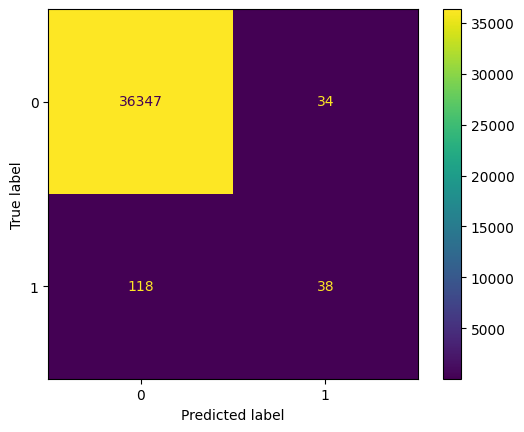

In [73]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

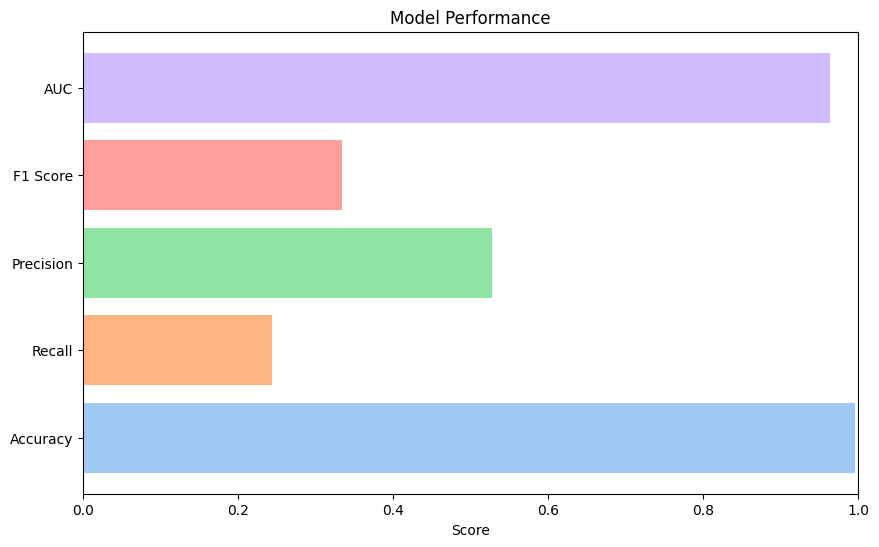

In [74]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [75]:
from sklearn.metrics import average_precision_score, auc

precision2, recall2, threshold = precision_recall_curve(y_test, y_pred_binary)
prauc = auc(precision2, recall2)
print("PRAUC: ", prauc)


PRAUC:  0.383028917647934


In [76]:
threshold

array([0., 1.])

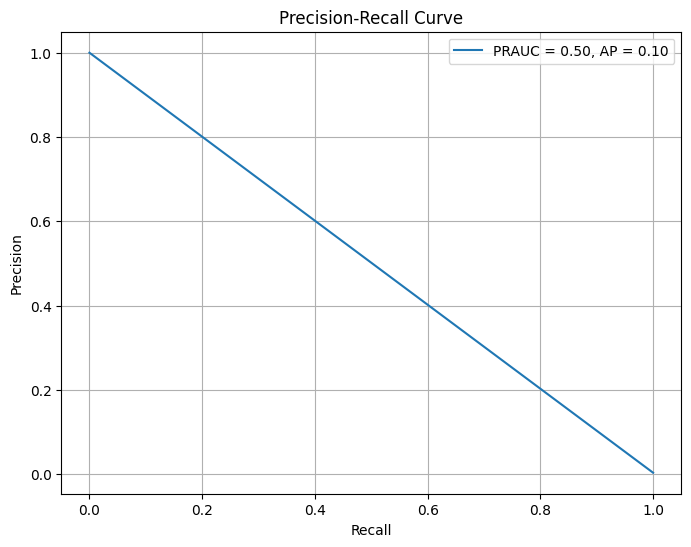

In [53]:
# Calculate the Average Precision (AP) to display in the plot
ap = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall2, precision2, label=f'PRAUC = {prauc:.2f}, AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [77]:
ap

0.10249525745646475

In [55]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
21          net_working_capital        2798
10                          m2b        2371
15              DTDmedianNonFin        2358
17                        gvkey        2208
24                 equity_ratio        1969
22                   debt_ratio        1953
33     working_capital_turnover        1951
27             return_on_assets        1845
8                     sizelevel        1787
23         debt_to_equity_ratio        1747
19                  quick_ratio        1662
4                liqnonfinlevel        1643
28               asset_turnover        1603
34            price_to_earnings        1581
6                    ni2talevel        1569
18                current_ratio        1553
43                         macd        1546
1                         STInt        1527
2                      dtdlevel        1453
30            days_in_inventory        1396
5                liqnonfintrend        1395
44                       macd_h 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


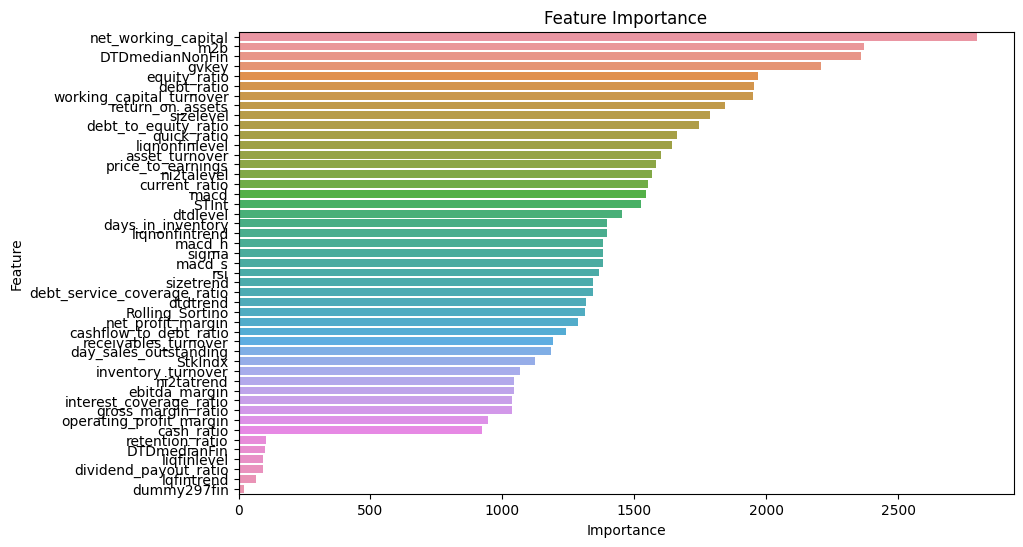

In [57]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

In [60]:
model = LGBMClassifier()
model.fit(x_train_scaled, y_train)

pred = model.predict(x_test_scaled)
y_pred_binary = np.round(pred)

NameError: name 'x_train_scaled' is not defined

In [ ]:
print('Training accuracy {:.4f}'.format(model.score(X_train_scaled,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test_scaled,y_test)))

Training accuracy 0.9921
Testing accuracy 0.9919


In [ ]:
print(metrics.classification_report(y_test,model.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    115004
         1.0       0.28      0.07      0.11       839
         2.0       0.00      0.00      0.00         2

    accuracy                           0.99    115845
   macro avg       0.42      0.36      0.37    115845
weighted avg       0.99      0.99      0.99    115845



<font size="6">Testing LightGBM model with filled_table</font>

In [ ]:
from google.oauth2 import service_account
import pandas as pd
import pandas_gbq as gbq
credentials_path = 'data_cleaning/token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [ ]:
project_id = 'capstone-398012'
dataset_id = 'capstone'
table_id = "filled_table"

In [ ]:
from pandas_gbq import read_gbq

query = f"""
SELECT *
FROM `{project_id}.{dataset_id}.{table_id}`

"""

# Authenticate and read data from BigQuery into a DataFrame
df = read_gbq(query, project_id=project_id, dialect='standard')
df

/usr/local/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2155: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,CompNo,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,nan_count,liqnonfinlevel_notNA,liqnonfintrend_notNA,dtdlevel_notNA,dtdtrend_notNA,DTDmedianNonFin_notNA,Sector_Number_notNA,DTDmedianFin_notNA,sigma_notNA,StkIndx_notNA
0,26995,1990,1,0.106263,0.020305,3.176331,-0.148469,0.280325,-0.146216,0.002395,...,3,1,1,0,0,0,1,1,1,1
1,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
2,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
3,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
4,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12334,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12335,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12336,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12337,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1


In [ ]:
#drop na rows
test_df = df.dropna()
test_df

,CompNo,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,nan_count,liqnonfinlevel_notNA,liqnonfintrend_notNA,dtdlevel_notNA,dtdtrend_notNA,DTDmedianNonFin_notNA,Sector_Number_notNA,DTDmedianFin_notNA,sigma_notNA,StkIndx_notNA
0,26995,1990,1,0.106263,0.020305,3.176331,-0.148469,0.280325,-0.146216,0.002395,...,3,1,1,0,0,0,1,1,1,1
1,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
2,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
3,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
4,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12334,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12335,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12336,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12337,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1


In [ ]:
#map event type
test_df['Event_type'] = test_df['Event_type'].map(lambda x : 0 if x ==2  else x)
test_df

/var/folders/rz/d40gjr2505ddk3wl3mnzmvdm0000gn/T/ipykernel_15768/3448417843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Event_type'] = test_df['Event_type'].map(lambda x : 0 if x ==2  else x)


,CompNo,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,nan_count,liqnonfinlevel_notNA,liqnonfintrend_notNA,dtdlevel_notNA,dtdtrend_notNA,DTDmedianNonFin_notNA,Sector_Number_notNA,DTDmedianFin_notNA,sigma_notNA,StkIndx_notNA
0,26995,1990,1,0.106263,0.020305,3.176331,-0.148469,0.280325,-0.146216,0.002395,...,3,1,1,0,0,0,1,1,1,1
1,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
2,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
3,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
4,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12334,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12335,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12336,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12337,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1


In [ ]:
X = test_df.drop(['Event_type', 'yyyy', 'mm', 'EventDate'], axis=1)  # Features
y = test_df['Event_type']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class_weights = {0:1, 1:100}
model = LGBMClassifier( class_weight = class_weights)
model.fit(X_train, y_train)
pred = model.predict(X_test)

[LightGBM] [Info] Number of positive: 727, number of negative: 9015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4108
[LightGBM] [Info] Number of data points in the train set: 9742, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.889678 -> initscore=2.087452
[LightGBM] [Info] Start training from score 2.087452


In [ ]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 0.7540
Testing accuracy 0.6773


In [ ]:
print(metrics.classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.68      0.80      2254
           1       0.14      0.67      0.24       182

    accuracy                           0.68      2436
   macro avg       0.55      0.67      0.52      2436
weighted avg       0.90      0.68      0.75      2436



push updated table to gbq, ie the table used for modeling

In [ ]:
new_df = df.dropna()
new_df = new_df.drop(['yyyy', 'mm', 'EventDate'], axis=1,)
new_df['Event_type'] = new_df['Event_type'].map(lambda x : 0 if x ==2  else x)
new_df

,CompNo,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,...,nan_count,liqnonfinlevel_notNA,liqnonfintrend_notNA,dtdlevel_notNA,dtdtrend_notNA,DTDmedianNonFin_notNA,Sector_Number_notNA,DTDmedianFin_notNA,sigma_notNA,StkIndx_notNA
0,26995,0.106263,0.020305,3.176331,-0.148469,0.280325,-0.146216,0.002395,0.001367,0.666644,...,3,1,1,0,0,0,1,1,1,1
1,26996,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,-0.000224,0.014110,...,3,1,1,0,0,0,1,1,1,1
2,26996,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,-0.000224,0.014110,...,3,1,1,0,0,0,1,1,1,1
3,27000,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,0.004625,1.248517,...,3,1,1,0,0,0,1,1,1,1
4,27000,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,0.004625,1.248517,...,3,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12334,27058,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,0.000547,5.101596,...,0,1,1,1,1,1,1,1,1,1
12335,27058,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,0.000547,5.101596,...,0,1,1,1,1,1,1,1,1,1
12336,27058,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,0.000547,5.101596,...,0,1,1,1,1,1,1,1,1,1
12337,27058,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,0.000547,5.101596,...,0,1,1,1,1,1,1,1,1,1


In [ ]:
new_df.to_gbq(destination_table=f'{project_id}.{dataset_id}.filled_table', project_id=project_id, if_exists='replace')